# Retailer X Use Case (Data Science Bootcamp, August 14 to 16th, 2018)

This is a rewrite of the Data Science bootcamp using Python. Another one was done using SPSS

## First, get the project token to use it to access the data files

In [234]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='01cb8ab3-b48d-441d-8d33-edc6caae425d', project_access_token='p-d36f9300425b2c63be8cd6c20d68a07ef91ec977')
pc = project.project_context


## Next, load the data files

In [235]:
import pandas as pd

# Fetch the Customer file
my_file = project.get_file("Customer Data Set - Student 1 of 3.xlsx")

# Read the EXCEl data file from the object storage into a pandas DataFrame
my_file.seek(0)
cust_df = pd.read_excel(my_file)
print(cust_df.dtypes)
print("\nNumber of customers: {}".format(len(cust_df)))
cust_df.head()

CUSTOMER ID                  int64
GENDER                       int64
AGE                          int64
INCOME                       int64
EXPERIENCE SCORE             int64
LOYALTY GROUP               object
ENROLLMENT DATE     datetime64[ns]
HOUSEHOLD SIZE               int64
MARITAL STATUS              object
dtype: object

Number of customers: 500


,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,133498,5,enrolled,2013-03-06,4,Single
1,10002,0,42,94475,9,not enrolled,NaT,6,Married
2,10003,0,40,88610,9,enrolled,2010-09-02,5,Married
3,10004,0,38,84313,8,enrolled,2015-04-06,1,Single
4,10005,0,30,51498,3,not enrolled,NaT,1,Single


In [236]:
#Next the Product file
my_file = project.get_file("Product Data Set - Student 2 of 3.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
prod_df = pd.read_csv(my_file, sep = '|')
print(prod_df.dtypes)
prod_df.head()

PRODUCT CODE          int64
PRODUCT CATEGORY     object
UNIT LIST PRICE      object
Unnamed: 3          float64
dtype: object


,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE,Unnamed: 3
0,30001,HEALTH & BEAUTY,$7.45,NaN
1,30002,HEALTH & BEAUTY,$5.35,NaN
2,30003,HEALTH & BEAUTY,$5.49,NaN
3,30004,HEALTH & BEAUTY,$6.46,NaN
4,30005,HEALTH & BEAUTY,$7.33,NaN


In [237]:
#Finally the Transcations file
my_file = project.get_file("Transaction Data Set - Student 3 of 3.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
trans_df = pd.read_csv(my_file, sep = '|', infer_datetime_format = True, parse_dates = [4])
print(trans_df.dtypes)
trans_df.head()

CUSTOMER NUM                   int64
PRODUCT NUM                    int64
QUANTITY PURCHASED             int64
DISCOUNT TAKEN               float64
TRANSACTION DATE      datetime64[ns]
STOCKOUT                       int64
dtype: object


,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,2015-01-02,0
1,10217,30016,3,0.0,2015-01-02,0
2,10224,30013,4,0.0,2015-01-02,0
3,10103,30012,3,0.2,2015-01-02,0
4,10037,30010,8,0.0,2015-01-02,0


## Feature Engineering / Data Preparation

In [238]:
# Next do some tranforms to prepare for modeling
cust_df['LOYALTY GROUP'] = cust_df['LOYALTY GROUP'].replace(('enrolled', 'not enrolled'), (1, 0))
cust_df = pd.get_dummies(cust_df, columns = ['MARITAL STATUS'])
print(cust_df.dtypes)
cust_df.head()

CUSTOMER ID                              int64
GENDER                                   int64
AGE                                      int64
INCOME                                   int64
EXPERIENCE SCORE                         int64
LOYALTY GROUP                            int64
ENROLLMENT DATE                 datetime64[ns]
HOUSEHOLD SIZE                           int64
MARITAL STATUS_Divorced                  uint8
MARITAL STATUS_Married                   uint8
MARITAL STATUS_Single                    uint8
MARITAL STATUS_Widow/Widower             uint8
dtype: object


,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower
0,10001,0,64,133498,5,1,2013-03-06,4,0,0,1,0
1,10002,0,42,94475,9,0,NaT,6,0,1,0,0
2,10003,0,40,88610,9,1,2010-09-02,5,0,1,0,0
3,10004,0,38,84313,8,1,2015-04-06,1,0,0,1,0
4,10005,0,30,51498,3,0,NaT,1,0,0,1,0


In [239]:
# Make price a float
prod_df.drop('Unnamed: 3', axis=1, inplace=True)
prod_df.dtypes
prod_df['UNIT LIST PRICE'] = prod_df['UNIT LIST PRICE'].replace('\$', '', regex=True)
prod_df['UNIT LIST PRICE'] = prod_df['UNIT LIST PRICE'].astype('float')
print(prod_df.dtypes)
prod_df.head()

PRODUCT CODE          int64
PRODUCT CATEGORY     object
UNIT LIST PRICE     float64
dtype: object


,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,7.45
1,30002,HEALTH & BEAUTY,5.35
2,30003,HEALTH & BEAUTY,5.49
3,30004,HEALTH & BEAUTY,6.46
4,30005,HEALTH & BEAUTY,7.33


In [240]:
# rename product key in trans dataframe
trans_df.rename(columns={'PRODUCT NUM': 'PRODUCT CODE', 'CUSTOMER NUM': 'CUSTOMER ID'}, inplace=True)

# Get product category and unit price and add them to the transaction table
trans_df2 = trans_df.merge(prod_df, on = 'PRODUCT CODE', how='inner')
trans_df2 # this is a new dataframe, changing a value in trans_df2 will not change it in trans_df

# Calculate Transaction total
trans_df2['TRANSACTION TOTAL'] = trans_df2['QUANTITY PURCHASED'] * trans_df2['UNIT LIST PRICE'] * (1 - trans_df2['DISCOUNT TAKEN'])
trans_df2.head()

# Transform PRODUCT CATEGORY to flag
trans_df2 = pd.get_dummies(trans_df2, columns = ['PRODUCT CATEGORY'])
trans_df2

# Aggregate on CUSTOMER ID

,CUSTOMER ID,PRODUCT CODE,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT,UNIT LIST PRICE,TRANSACTION TOTAL,PRODUCT CATEGORY_APPAREL,PRODUCT CATEGORY_ELECTRONICS,PRODUCT CATEGORY_FOOD,PRODUCT CATEGORY_HEALTH & BEAUTY
0,10114,30011,4,0.0,2015-01-02,0,25.46,101.840,1,0,0,0
1,10086,30011,6,0.0,2015-01-02,0,25.46,152.760,1,0,0,0
2,10174,30011,10,0.0,2015-01-02,0,25.46,254.600,1,0,0,0
3,10401,30011,12,0.0,2015-01-02,0,25.46,305.520,1,0,0,0
4,10216,30011,12,0.1,2015-01-02,0,25.46,274.968,1,0,0,0
5,10204,30011,15,0.0,2015-01-02,0,25.46,381.900,1,0,0,0
6,10475,30011,14,0.0,2015-01-02,0,25.46,356.440,1,0,0,0
7,10493,30011,13,0.0,2015-01-02,0,25.46,330.980,1,0,0,0
8,10229,30011,4,0.0,2015-01-03,0,25.46,101.840,1,0,0,0
9,10494,30011,7,0.0,2015-01-03,0,25.46,178.220,1,0,0,0


In [241]:
pd.set_option('display.width', 3000)
pd.set_option('display.max.columns', 500)
pd.set_option('display.max.rows', 20)

grouped = trans_df2.groupby(['CUSTOMER ID']).agg(['sum', 'mean', 'max'])
grouped = grouped.reset_index()
type(grouped.columns)
grouped.columns = grouped.columns.map('_'.join)
grouped.columns.values[0] = 'CUSTOMER ID'

grouped.dtypes

CUSTOMER ID                                int64
PRODUCT CODE_sum                           int64
PRODUCT CODE_mean                        float64
PRODUCT CODE_max                           int64
QUANTITY PURCHASED_sum                     int64
QUANTITY PURCHASED_mean                  float64
QUANTITY PURCHASED_max                     int64
DISCOUNT TAKEN_sum                       float64
DISCOUNT TAKEN_mean                      float64
DISCOUNT TAKEN_max                       float64
                                          ...   
PRODUCT CATEGORY_APPAREL_max               uint8
PRODUCT CATEGORY_ELECTRONICS_sum           uint8
PRODUCT CATEGORY_ELECTRONICS_mean        float64
PRODUCT CATEGORY_ELECTRONICS_max           uint8
PRODUCT CATEGORY_FOOD_sum                  uint8
PRODUCT CATEGORY_FOOD_mean               float64
PRODUCT CATEGORY_FOOD_max                  uint8
PRODUCT CATEGORY_HEALTH & BEAUTY_sum       uint8
PRODUCT CATEGORY_HEALTH & BEAUTY_mean    float64
PRODUCT CATEGORY_HEA

In [242]:
cust_df2 = cust_df.merge(grouped, on = 'CUSTOMER ID', how='inner')

columns_to_keep = ['CUSTOMER ID', 'GENDER' , 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'LOYALTY GROUP', 'ENROLLMENT DATE', 'HOUSEHOLD SIZE', 'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married', 'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower', 'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 'DISCOUNT TAKEN_max', 'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean', 'PRODUCT CATEGORY_APPAREL_max', 'PRODUCT CATEGORY_ELECTRONICS_max', 'PRODUCT CATEGORY_FOOD_max', 'PRODUCT CATEGORY_HEALTH & BEAUTY_max']

cust_df2 = cust_df2[columns_to_keep]

cust_df2.loc[cust_df2['DISCOUNT TAKEN_max'] > 0, 'DISCOUNT TAKEN_max'] = 1

cust_df2

,CUSTOMER ID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS_Divorced,MARITAL STATUS_Married,MARITAL STATUS_Single,MARITAL STATUS_Widow/Widower,QUANTITY PURCHASED_sum,QUANTITY PURCHASED_mean,DISCOUNT TAKEN_max,TRANSACTION TOTAL_sum,TRANSACTION TOTAL_mean,PRODUCT CATEGORY_APPAREL_max,PRODUCT CATEGORY_ELECTRONICS_max,PRODUCT CATEGORY_FOOD_max,PRODUCT CATEGORY_HEALTH & BEAUTY_max
0,10001,0,64,133498,5,1,2013-03-06,4,0,0,1,0,396,14.666667,1.0,6826.770,252.843333,1,1,1,1
1,10002,0,42,94475,9,0,NaT,6,0,1,0,0,202,8.416667,1.0,5062.451,210.935458,1,1,1,0
2,10003,0,40,88610,9,1,2010-09-02,5,0,1,0,0,265,11.521739,1.0,8562.440,372.280000,1,1,1,0
3,10004,0,38,84313,8,1,2015-04-06,1,0,0,1,0,197,10.368421,1.0,5522.694,290.668105,1,1,1,0
4,10005,0,30,51498,3,0,NaT,1,0,0,1,0,12,6.000000,1.0,213.512,106.756000,1,0,0,0
5,10006,1,63,132893,1,0,NaT,4,0,1,0,0,309,11.444444,1.0,5234.847,193.883222,1,1,1,1
6,10007,0,33,65002,9,1,2014-01-01,4,0,1,0,0,139,9.928571,1.0,5224.616,373.186857,1,1,1,0
7,10008,0,49,115672,9,1,2009-05-27,6,0,0,1,0,265,13.250000,1.0,8412.001,420.600050,1,1,1,0
8,10009,0,44,101741,9,1,2006-01-06,3,0,1,0,0,273,12.409091,1.0,9116.576,414.389818,1,1,1,0
9,10010,0,36,76994,2,0,NaT,2,0,1,0,0,202,8.080000,1.0,6620.147,264.805880,1,1,1,0


## Feature Selection

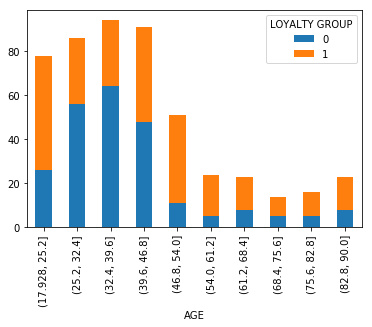

In [243]:
import matplotlib.pyplot as plt
%matplotlib inline
bins = pd.cut(cust_df2['AGE'], bins = 10)
tab = pd.crosstab(bins, cust_df2['LOYALTY GROUP'],margins=True)
tab = tab.drop('All',axis=1)
tab = tab.drop('All',axis=0)
tab.plot(kind='bar', stacked = True)
plt.show()

In [244]:
numeric_features = ['AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE', 'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean']
cust_df2[numeric_features].corr()

,AGE,INCOME,EXPERIENCE SCORE,HOUSEHOLD SIZE,QUANTITY PURCHASED_sum,QUANTITY PURCHASED_mean,TRANSACTION TOTAL_sum,TRANSACTION TOTAL_mean
AGE,1.000000,0.941799,0.063957,0.029117,0.694876,0.850227,0.576017,0.648537
INCOME,0.941799,1.000000,0.035139,0.143772,0.735721,0.892511,0.688031,0.776399
EXPERIENCE SCORE,0.063957,0.035139,1.000000,-0.056569,0.183007,0.177476,0.136564,0.105325
HOUSEHOLD SIZE,0.029117,0.143772,-0.056569,1.000000,0.171280,0.106077,0.251744,0.203744
QUANTITY PURCHASED_sum,0.694876,0.735721,0.183007,0.171280,1.000000,0.829303,0.869524,0.656066
QUANTITY PURCHASED_mean,0.850227,0.892511,0.177476,0.106077,0.829303,1.000000,0.724786,0.807722
TRANSACTION TOTAL_sum,0.576017,0.688031,0.136564,0.251744,0.869524,0.724786,1.000000,0.851646
TRANSACTION TOTAL_mean,0.648537,0.776399,0.105325,0.203744,0.656066,0.807722,0.851646,1.000000


## Feature Scaling

In [245]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

#features = ['GENDER' , 'AGE', 'INCOME', 'EXPERIENCE SCORE', 'HOUSEHOLD SIZE', 'MARITAL STATUS_Divorced', 'MARITAL STATUS_Married', 'MARITAL STATUS_Single', 'MARITAL STATUS_Widow/Widower', 'QUANTITY PURCHASED_sum', 'QUANTITY PURCHASED_mean', 'DISCOUNT TAKEN_max', 'TRANSACTION TOTAL_sum', 'TRANSACTION TOTAL_mean', 'PRODUCT CATEGORY_APPAREL_max', 'PRODUCT CATEGORY_ELECTRONICS_max', 'PRODUCT CATEGORY_FOOD_max', 'PRODUCT CATEGORY_HEALTH & BEAUTY_max']
features = ['INCOME', 'EXPERIENCE SCORE', 'QUANTITY PURCHASED_sum', 'DISCOUNT TAKEN_max', 'TRANSACTION TOTAL_sum']
numeric_features = ['INCOME', 'EXPERIENCE SCORE', 'QUANTITY PURCHASED_sum', 'TRANSACTION TOTAL_sum']
target = 'LOYALTY GROUP'

# ALWAYS SPLIT FIRST BEFORE SCALING TO AVOID PREDICTOR LEAKAGE !!!!!
X = cust_df2[features]
y = cust_df2[target]

#Train Test Split, reserve test subset for finally accuracy and other metrics calculations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(X_train) # fit the scaler on training data then apply to training and test data
X_train = scaler.transform(X_train)
X_test =  scaler.transform(X_test)

## Trying Different Models

In [246]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# using specific random state to make sure we always get same accuracy result if we execute this cell multiple times or on multiple machines

logreg = LogisticRegression(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
print("Logistic regression accuracy is:", scores.mean())

svc = svm.SVC(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
print("SVM accuracy is: ", scores.mean())

rc = RandomForestClassifier(random_state=1)
# 10-fold cross-validation, calculating average training accuracy
scores = cross_val_score(rc, X_train, y_train, cv=10, scoring='accuracy')
print("Random forest accuracy is: ", scores.mean())

Logistic regression accuracy is: 0.851615312792
SVM accuracy is:  0.825980392157
Random forest accuracy is:  0.85439309057


# Use Random Search Cross Validation to fine tune the selected model hyperparameters

In [247]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

#C_options = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#solver_options = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
#multi_class_options = ['ovr']
#class_weight_options = [None, 'balanced']
#param_grid = dict(C = C_options)

#clf = GridSearchCV(LogisticRegression(), param_grid)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 5, 10] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4] # Minimum number of samples required at each leaf node
bootstrap = [True, False] # Method of selecting samples for training each tree

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

clf = RandomizedSearchCV(RandomForestClassifier(random_state = 1), param_grid, random_state=1)
clf.fit(X_train, y_train)
best_model = clf.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

## Use the tuned model to find testing accuracy

In [248]:
y_pred = best_model.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

print('\nAccuracy of tuned model on test set: {}\n'.format(best_model.score(X_test, y_test)))

print(classification_report(y_test, y_pred))

[[59 15]
 [ 7 69]]

Accuracy of tuned model on test set: 0.8533333333333334

             precision    recall  f1-score   support

          0       0.89      0.80      0.84        74
          1       0.82      0.91      0.86        76

avg / total       0.86      0.85      0.85       150

